In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Volumetric Classification

In [ ]:
import os
import glob

def load_paths(folder_name):
  # Define the parent folder containing the '1' folder
  parent_folder = '/content/drive/MyDrive/datasets/OCT/final/dataset'

  # Define the folder containing the images
  images_folder = os.path.join(parent_folder, folder_name)

  # Define the list of image file extensions you want to include (e.g., jpg, png)
  image_extensions = ['jpg', 'jpeg', 'png', 'bmp', 'gif']

  # Use glob to retrieve all image file paths in the '1' folder
  image_paths = []
  for extension in image_extensions:
      # Define the pattern to match files with the specified extension
      pattern = os.path.join(images_folder, f'*.{extension}')
      # Use glob to find all files matching the pattern and add them to the list
      image_paths.extend(glob.glob(pattern))
  return image_paths



In [ ]:
images_1=load_paths("1")
images_2=load_paths("2")

In [ ]:
print(len(images_1),len(images_2))

139 658


In [ ]:
import numpy as np
from skimage import io, transform

def preprocess_image(image_path, target_shape):

    # Read the image using skimage.io
    image = io.imread(image_path, as_gray=True)  # Load the image as grayscale

    # Resize the image to the target shape
    image_resized = transform.resize(image, target_shape, mode='reflect', anti_aliasing=True)

    # Normalize the image pixel values to the range [0, 1]
    image_resized = image_resized / 255.0

    return image_resized

def stack_images(image_paths, target_shape):

    # Initialize an empty list to hold the stacked images
    stacked_images = []

    # Iterate over the image paths
    for i in range(0, len(image_paths), 3):
        # Read and preprocess three images
        image1 = preprocess_image(image_paths[i], target_shape)
        image2 = preprocess_image(image_paths[i + 1], target_shape) if i + 1 < len(image_paths) else np.zeros(target_shape)
        image3 = preprocess_image(image_paths[i + 2], target_shape) if i + 2 < len(image_paths) else np.zeros(target_shape)

        # Stack the three images along the depth axis
        stacked_image = np.stack([image1, image2, image3], axis=-1)

        # Add the stacked image to the list
        stacked_images.append(stacked_image)

    return stacked_images

# Example usage:
# Define the list of image paths
# Images_1 = ['path/to/image1.png', 'path/to/image2.png', ...]  # Replace with the paths of your images

# Define the target shape (height, width) for resizing the images
target_shape = (128, 128)  # Adjust as needed

# Call the stack_images function to get a list of stacked images
stacked_images1 = stack_images(images_1, target_shape)
stacked_images2 = stack_images(images_2, target_shape)

# Print the shape of the first stacked image to verify the dimensions
print('Shape of the first stacked image:', len(stacked_images1))
print('Shape of the second stacked image:', len(stacked_images2))


Shape of the first stacked image: 47
Shape of the second stacked image: 220


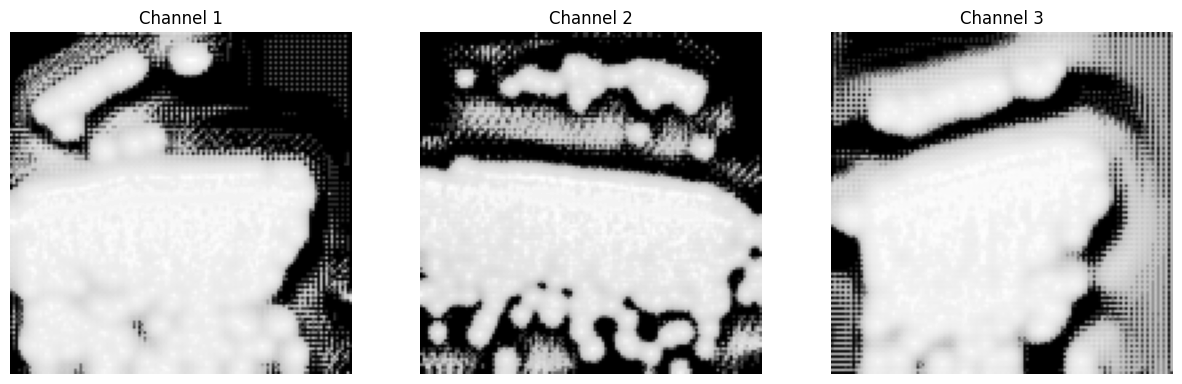

In [ ]:
import matplotlib.pyplot as plt

def plot_stacked_image(stacked_image):
    """
    Plot the first stacked image.

    Parameters:
        stacked_image (numpy.ndarray): The stacked image to plot.
    """
    # Check the depth of the image (number of channels)
    depth = stacked_image.shape[-1]

    # Create a figure
    plt.figure(figsize=(15, 5))

    # Plot each channel separately
    for i in range(depth):
        plt.subplot(1, depth, i + 1)
        plt.imshow(stacked_image[:, :, i], cmap='gray')
        plt.title(f'Channel {i + 1}')
        plt.axis('off')

    # Show the plots
    plt.show()

# Plot the first stacked image from the list
plot_stacked_image(stacked_images1[0])


In [ ]:
class_1_labels = [1] * len(stacked_images1)
class_2_labels = [2] * len(stacked_images2)

In [ ]:
len(class_2_labels)

220

In [ ]:
import numpy as np
import random

def combine_classes(class_1_images, class_2_images):

    # Create labels for each class
    class_1_labels = [0] * len(class_1_images)
    class_2_labels = [1] * len(class_2_images)

    # Combine images and labels from both classes
    combined_images = class_1_images + class_2_images
    combined_labels = class_1_labels + class_2_labels

    # Shuffle the data to randomize the order
    combined_data = list(zip(combined_images, combined_labels))
    random.shuffle(combined_data)
    combined_images, combined_labels = zip(*combined_data)

    return list(combined_images), list(combined_labels)

# Example usage:
# Assume you have lists of images for class 1 and class 2
# Combine the images and labels from both classes
images, labels = combine_classes(stacked_images1, stacked_images2)

# Convert images and labels to numpy arrays for further processing
images = np.array(images)
labels = np.array(labels)

print('Combined images shape:', images.shape)
print('Combined labels shape:', labels.shape)


Combined images shape: (267, 128, 128, 3)
Combined labels shape: (267,)


In [ ]:
from sklearn.model_selection import train_test_split

def split_dataset(images, labels, test_size=0.2, random_state=42, stratify=True):

    # If stratification is enabled, use labels for stratifying the split
    stratify_labels = labels if stratify else None

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=test_size, random_state=random_state, stratify=stratify_labels
    )

    return X_train, X_test, y_train, y_test

# Example usage:
# Assume `images` and `labels` are numpy arrays representing the combined images and labels

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = split_dataset(images, labels)

# Print the shapes of the training and test sets
print('Training data shape:', X_train.shape)
print('Training labels shape:', y_train.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)


Training data shape: (213, 128, 128, 3)
Training labels shape: (213,)
Test data shape: (54, 128, 128, 3)
Test labels shape: (54,)


In [ ]:
import numpy as np

# Given training dataset X_train of shape (num_images, 128, 128, 3)
# Here, num_images is the number of images in your training dataset
# Example: num_images = 377

# Assuming X_train is already defined
num_images = X_train.shape[0]

# Initialize a new array to hold the reshaped images
X_train_reshaped = np.empty((num_images, 3, 128, 128))

# Iterate over each image in X_train
for i in range(num_images):
    # Reshape the image from shape (128, 128, 3) to (3, 128, 128) using np.transpose
    X_train_reshaped[i] = np.transpose(X_train[i], (2, 0, 1))

# Print the shapes of the original and reshaped datasets
print('Original X_train shape:', X_train.shape)  # Should be (num_images, 128, 128, 3)
print('Reshaped X_train shape:', X_train_reshaped.shape)  # Should be (num_images, 3, 128, 128)


Original X_train shape: (213, 128, 128, 3)
Reshaped X_train shape: (213, 3, 128, 128)


In [ ]:
import numpy as np

# Given training dataset X_train of shape (num_images, 128, 128, 3)
# Here, num_images is the number of images in your training dataset
# Example: num_images = 377

# Assuming X_train is already defined
num_images = X_test.shape[0]

# Initialize a new array to hold the reshaped images
X_test_reshaped = np.empty((num_images, 3, 128, 128))

# Iterate over each image in X_train
for i in range(num_images):
    # Reshape the image from shape (128, 128, 3) to (3, 128, 128) using np.transpose
    X_test_reshaped[i] = np.transpose(X_test[i], (2, 0, 1))

# Print the shapes of the original and reshaped datasets
print('Original X_test shape:', X_test.shape)  # Should be (num_images, 128, 128, 3)
print('Reshaped X_testshape:', X_test_reshaped.shape)  # Should be (num_images, 3, 128, 128)


Original X_test shape: (54, 128, 128, 3)
Reshaped X_testshape: (54, 3, 128, 128)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def get_model(width=128, height=128, depth=3):
    """Build a 3D convolutional neural network model for grayscale images with a depth of 3."""

    # Define the input shape with depth of 3 and a single channel (grayscale images)
    input_shape = (depth, height, width, 1)
    inputs = tf.keras.Input(shape=input_shape)

    # Define the 3D CNN architecture
    x = layers.Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Global average pooling layer to flatten the output
    x = layers.GlobalAveragePooling3D()(x)

    # Fully connected layer
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Output layer for binary classification
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs, name='3dcnn')

    return model

# Create and summarize the model
model = get_model(width=128, height=128, depth=3)
model.summary()


Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 128, 128, 1)   0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 3, 128, 128, 64)   1792      
                                                                 
 max_pooling3d (MaxPooling3  (None, 2, 64, 64, 64)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 2, 64, 64, 64)     256       
 Normalization)                                                  
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 64, 64, 64)     110656    
                                                             

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
    run_eagerly=True,
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.keras", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

In [ ]:
epochs = 100
model.fit(
    X_train_reshaped,  # Input data for training
    y_train,  # Labels for training
    validation_data=(X_test_reshaped, y_test),
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100


7/7 - 13s - loss: 0.5656 - acc: 0.7840 - val_loss: 0.6869 - val_acc: 0.8148 - 13s/epoch - 2s/step
Epoch 2/100
7/7 - 1s - loss: 0.4296 - acc: 0.8357 - val_loss: 0.6794 - val_acc: 0.8148 - 1s/epoch - 189ms/step
Epoch 3/100
7/7 - 1s - loss: 0.3867 - acc: 0.8404 - val_loss: 0.6716 - val_acc: 0.8148 - 1s/epoch - 190ms/step
Epoch 4/100
7/7 - 1s - loss: 0.3704 - acc: 0.8638 - val_loss: 0.6638 - val_acc: 0.8148 - 1s/epoch - 189ms/step
Epoch 5/100
7/7 - 1s - loss: 0.3535 - acc: 0.8451 - val_loss: 0.6554 - val_acc: 0.8148 - 1s/epoch - 173ms/step
Epoch 6/100
7/7 - 1s - loss: 0.3284 - acc: 0.8826 - val_loss: 0.6477 - val_acc: 0.8148 - 1s/epoch - 179ms/step
Epoch 7/100
7/7 - 1s - loss: 0.3149 - acc: 0.8732 - val_loss: 0.6380 - val_acc: 0.8148 - 1s/epoch - 180ms/step
Epoch 8/100
7/7 - 1s - loss: 0.3258 - acc: 0.8732 - val_loss: 0.6299 - val_acc: 0.8148 - 1s/epoch - 181ms/step
Epoch 9/100
7/7 - 1s - loss: 0.2999 - acc: 0.8779 - val_loss: 0.6216 - val_acc: 0.8148 - 1s/epoch - 180ms/step
Epoch 10/100
7

##Feature Visualization

In [ ]:
from tensorflow.keras import models
import matplotlib.pyplot as plt

# Extract intermediate layers' outputs
layer_outputs = [layer.output for layer in model.layers]

# Create a model that outputs the intermediate layers' values
intermediate_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Get feature maps from a sample input (X_test[0])
sample_input = np.expand_dims(X_test_reshaped[0], axis=0)
feature_maps = intermediate_model.predict(sample_input)



1/1 [==============================] - 0s 382ms/step


In [ ]:
len(feature_maps)

17

In [ ]:
reshaped_image = np.transpose(feature_maps[0].squeeze(), (1, 2, 0))
reshaped_image.shape

(128, 128, 3)

In [ ]:
feature_map=feature_maps[0].squeeze()

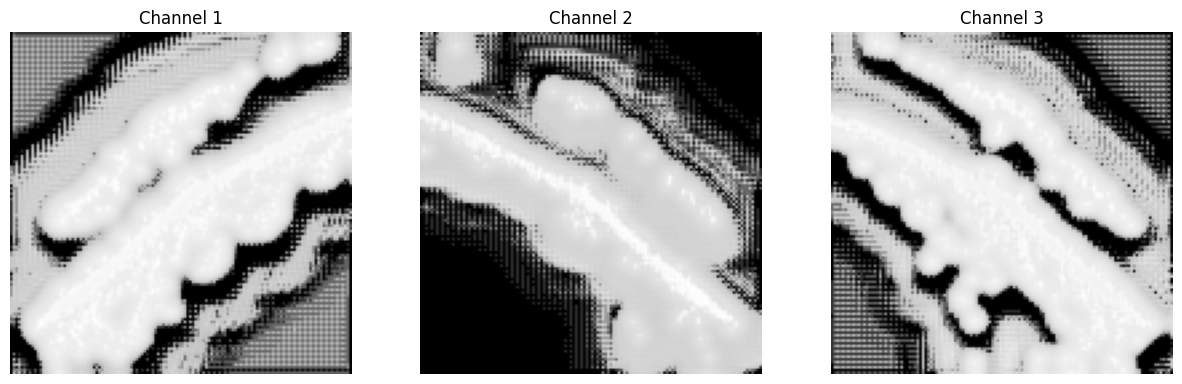

In [ ]:
import matplotlib.pyplot as plt

def plot_stacked_image(stacked_image):

    # Check the depth of the image (number of channels)
    depth = stacked_image.shape[-1]

    # Create a figure
    plt.figure(figsize=(15, 5))

    # Plot each channel separately
    for i in range(depth):
        plt.subplot(1, depth, i + 1)
        plt.imshow(stacked_image[:, :, i], cmap='gray')
        plt.title(f'Channel {i + 1}')
        plt.axis('off')

    # Show the plots
    plt.show()

# Plot the first stacked image from the list
plot_stacked_image(reshaped_image)
